In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

import joblib

from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict
from sklearn.tree import export_text
from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


2025-08-18 23:28:24.165435: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-18 23:28:24.166218: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-18 23:28:24.168923: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-18 23:28:24.176227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755570504.188455   76130 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755570504.19

In [11]:
#FRAGMENTA ARQUIVO - RADHA

# === 1. Carrega o arquivo original ===
df = pd.read_csv("arquivos/V2-RADHA-dataset_com_risco.csv")

# === 2. Cria o dataset de entrada removendo as colunas de rótulo ===
# Removerá 'risco' e 'risco_pontos' se existirem
colunas_para_remover = ['risco', 'risco_pontos']
colunas_presentes = [col for col in colunas_para_remover if col in df.columns]
df_entrada = df.drop(columns=colunas_presentes)

# === 3. Cria o arquivo de gabarito ===
# Se não existir a coluna 'risco', cria uma coluna vazia para evitar erro
if 'risco' in df.columns:
    df_gabarito = df[['risco']].copy()
else:
    df_gabarito = pd.DataFrame({'risco': []})

# === 4. Exporta os arquivos ===
df_entrada.to_csv("dataset_radha_sem_risco.csv", index=False)
df_gabarito.to_csv("gabarito_radha_risco.csv", index=False)

print("Arquivos exportados com sucesso")


Arquivos exportados com sucesso



🔹 Modelo Random Forest — Especialista - Não Balanceado
              precision    recall  f1-score   support

        Alto       1.00      1.00      1.00       108
       Baixo       1.00      1.00      1.00       248
       Médio       0.98      0.98      0.98        44

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



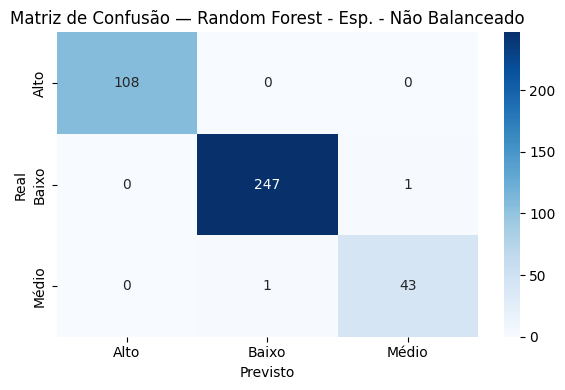

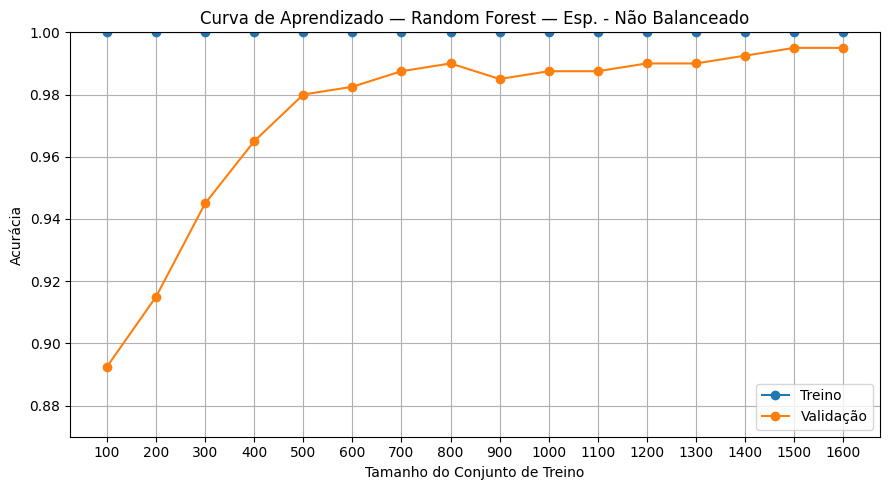

In [53]:
#RANDON FOREST - RADHA SEM BALANCEAR

# === Carrega os dados ===
dados_entrada = pd.read_csv("dataset_radha_sem_risco.csv")
rotulos_risco = pd.read_csv("gabarito_radha_risco.csv")["risco"]

# === 2. Codifica os dados ===
codificador_rotulos = LabelEncoder()
rotulos_convertidos = codificador_rotulos.fit_transform(rotulos_risco)

entradas_convertidas = dados_entrada.apply(LabelEncoder().fit_transform)

# === 3. Separação Hold-out ===
entradas_treino, entradas_teste, rotulos_treino, rotulos_teste = train_test_split(
    entradas_convertidas, rotulos_convertidos,
    test_size=0.2, random_state=42, stratify=rotulos_convertidos
)

# === 4. Treinamento com Random Forest ===
modelo_random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_random_forest.fit(entradas_treino, rotulos_treino)
rotulos_previstos = modelo_random_forest.predict(entradas_teste)

# === 5. Avaliação ===
print("\n🔹 Modelo Random Forest — Especialista - Não Balanceado")
print(classification_report(rotulos_teste, rotulos_previstos, target_names=codificador_rotulos.classes_))

# === 6. Matriz de Confusão ===
plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion_matrix(rotulos_teste, rotulos_previstos),
    annot=True, fmt='d', cmap='Blues',
    xticklabels=codificador_rotulos.classes_,
    yticklabels=codificador_rotulos.classes_
)
plt.title("Matriz de Confusão — Random Forest - Esp. - Não Balanceado")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("imagens/imagens/sem balancear/matriz-RD-ESP-01", dpi=300)
plt.show()

# === 7. Curva de Aprendizado Manual ===
tamanhos_amostras_treino = np.arange(100, len(entradas_treino) + 1, 100)
acuracias_treino = []
acuracias_teste = []

for tamanho_atual in tamanhos_amostras_treino:
    modelo_temporario = RandomForestClassifier(n_estimators=100, random_state=42)
    modelo_temporario.fit(entradas_treino[:tamanho_atual], rotulos_treino[:tamanho_atual])

    acuracia_treino_atual = accuracy_score(rotulos_treino[:tamanho_atual], modelo_temporario.predict(entradas_treino[:tamanho_atual]))
    acuracia_teste_atual = accuracy_score(rotulos_teste, modelo_temporario.predict(entradas_teste))

    acuracias_treino.append(acuracia_treino_atual)
    acuracias_teste.append(acuracia_teste_atual)

# === 8. Plot da Curva ===
plt.figure(figsize=(9, 5))
plt.plot(tamanhos_amostras_treino, acuracias_treino, 'o-', label="Treino")
plt.plot(tamanhos_amostras_treino, acuracias_teste, 'o-', label="Validação")

plt.title("Curva de Aprendizado — Random Forest — Esp. - Não Balanceado")
plt.xlabel("Tamanho do Conjunto de Treino")
plt.ylabel("Acurácia")
plt.xticks(tamanhos_amostras_treino)
plt.legend()
plt.legend(loc='lower right')
plt.grid(True)
plt.ylim(0.87, 1)
plt.tight_layout()
plt.savefig("imagens/imagens/sem balancear/CURVA-RD-ESP-01.png", dpi=300)
plt.show()

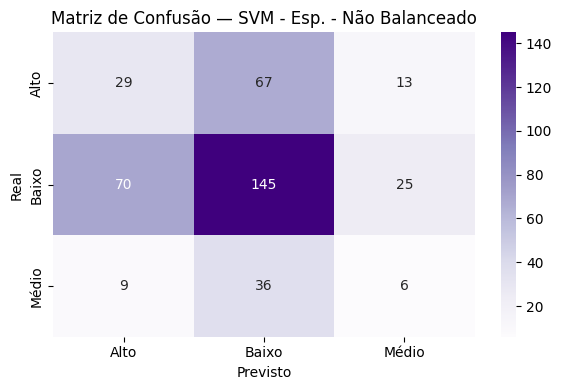

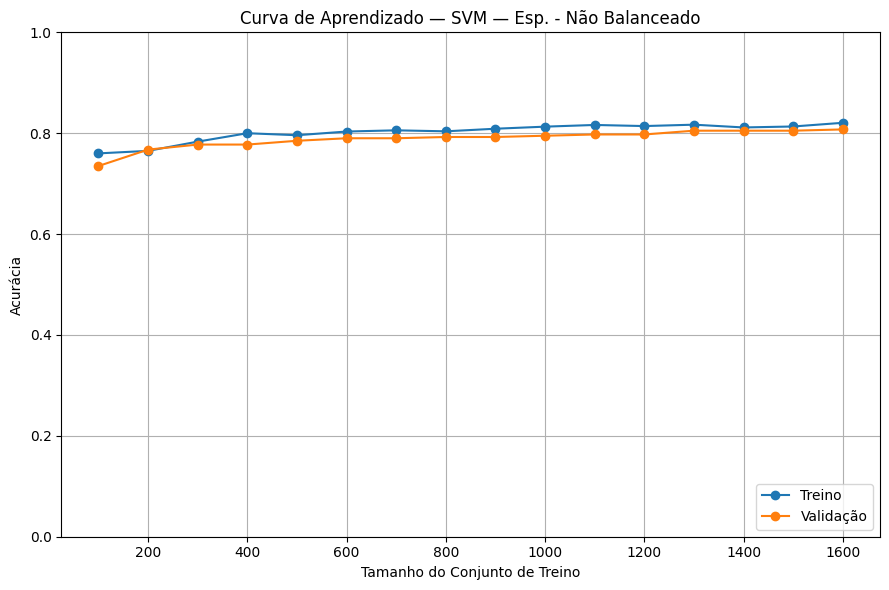

In [54]:
#SVM RADHA -SEM BALANCEAR

# === Carrega os dados ===
dados_entrada = pd.read_csv("dataset_radha_sem_risco.csv")
rotulos_risco = pd.read_csv("gabarito_radha_risco.csv")["risco"]

# === 2. Codifica entradas e rótulos ===
rotulo_encoder = LabelEncoder()
rotulos_codificados = rotulo_encoder.fit_transform(rotulos_risco)
entradas_codificadas = dados_entrada.apply(LabelEncoder().fit_transform)

# === 3. Hold-out 80/20 ===
entradas_treino, entradas_teste, rotulos_treino, rotulos_teste = train_test_split(
    entradas_codificadas, rotulos_codificados, test_size=0.2, random_state=42
)

# === 4. Define o modelo SVM ===
modelo_svm = SVC(kernel='rbf', C=1.0, gamma='scale')

# === 5. Define os tamanhos de treino manualmente ===
tamanhos_treino = np.arange(100, len(entradas_treino)+1, 100)

# === 6. Matriz de Confusão ===
plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion_matrix(rotulos_teste, rotulos_previstos),
    annot=True, fmt='d', cmap='Purples',
    xticklabels=rotulo_encoder.classes_,
    yticklabels=rotulo_encoder.classes_
)
plt.title("Matriz de Confusão — SVM - Esp. - Não Balanceado")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("imagens/imagens/sem balancear/MATRIZ-SVM-ESP-NO-BALANCE-01.png", dpi=300)
plt.show()

# === 7. Curva de aprendizado manual ===
scores_treino = []
scores_validacao = []

for tamanho in tamanhos_treino:
    modelo_svm.fit(entradas_treino[:tamanho], rotulos_treino[:tamanho])
    
    acc_train = accuracy_score(rotulos_treino[:tamanho], modelo_svm.predict(entradas_treino[:tamanho]))
    acc_test = accuracy_score(rotulos_teste, modelo_svm.predict(entradas_teste))
    
    scores_treino.append(acc_train)
    scores_validacao.append(acc_test)

# === 7. Plot ===
plt.figure(figsize=(9, 6))
plt.plot(tamanhos_treino, scores_treino, 'o-', label="Treino")
plt.plot(tamanhos_treino, scores_validacao, 'o-', label="Validação")

plt.title("Curva de Aprendizado — SVM — Esp. - Não Balanceado")
plt.xlabel("Tamanho do Conjunto de Treino")
plt.ylabel("Acurácia")
plt.legend()
plt.legend(loc='lower right')
plt.grid(True)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("imagens/imagens/sem balancear/CURVA-SVM-ESP-NO-BALANCE-01.png", dpi=300)
plt.show()

Arquivo balanceado salvo como 'dataset_radha_balanceado_SMOTE.csv'


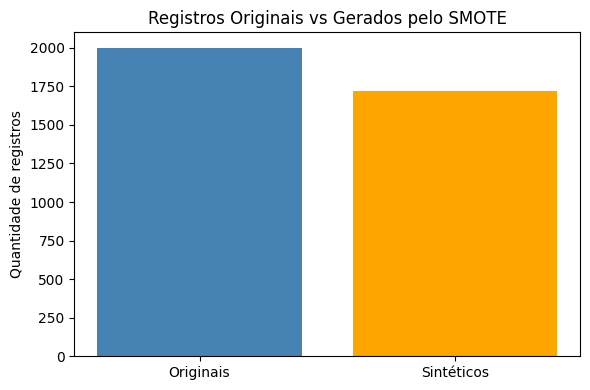

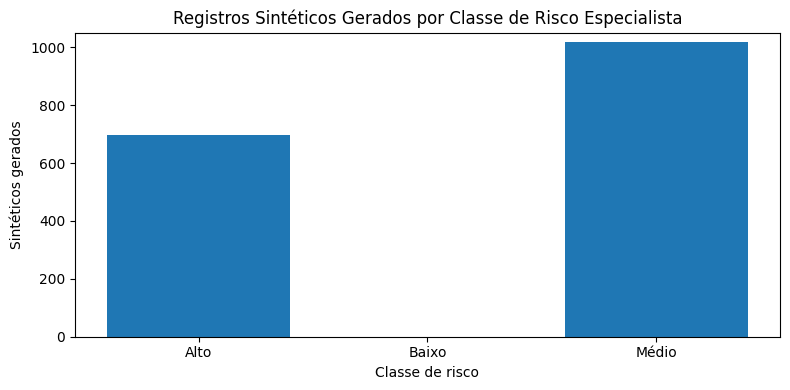

In [23]:
#GERAR ARQUIVO CSV RADHA - SMOTE - só gera novos valores, não há delete para balancear o arquivo

# === Carrega os dados ===
dados_entrada = pd.read_csv("dataset_radha_sem_risco.csv")
rotulos_risco = pd.read_csv("gabarito_radha_risco.csv")["risco"]

# === 2. Codifica rótulos e entradas ===
rotulo_encoder = LabelEncoder()
rotulos_codificados = rotulo_encoder.fit_transform(rotulos_risco)
entradas_codificadas = dados_entrada.apply(LabelEncoder().fit_transform)

# === 3. Aplica SMOTE (aumentando o dataset sem remoção de linhas) ===
smote = SMOTE(random_state=42)
entradas_balanceadas, rotulos_balanceados = smote.fit_resample(entradas_codificadas, rotulos_codificados)

# === 4. Reconstrói o dataframe com rótulo decodificado ===
df_balanceado = pd.DataFrame(entradas_balanceadas, columns=dados_entrada.columns)
df_balanceado["risco"] = rotulo_encoder.inverse_transform(rotulos_balanceados)

#ESSA PARTE É APENAS PARA CONTROLE DO QUE FOI GERADO. SE O DADO É ORIGINAL DO DATASET OU GERADO PELO SMOTE
# === 5. Marca se é original ou sintético ===
total_original = len(dados_entrada)
df_balanceado["origem"] = ["original"] * total_original + ["sintetico"] * (len(df_balanceado) - total_original)

# === 6. Exporta CSV ===
print("Arquivo balanceado salvo como 'dataset_radha_balanceado_SMOTE.csv'")
df_balanceado.to_csv("dataset_radha_balanceado_SMOTE.csv", index=False)

# Totais
total_original = len(dados_entrada)
total_balanceado = len(df_balanceado)
total_sintetico = total_balanceado - total_original

# --- Gráfico 1: Totais (Originais vs Sintéticos) ---
plt.figure(figsize=(6,4))
plt.bar(['Originais', 'Sintéticos'],
        [total_original, total_sintetico],
        color=["steelblue", "orange"])
plt.title('Registros Originais vs Gerados pelo SMOTE')
plt.ylabel('Quantidade de registros')
plt.tight_layout()
plt.savefig("imagens/grafico-registro-smote-radha.png", dpi=300)
plt.show()

# --- Gráfico 2 (opcional): Sintéticos por classe de risco ---
orig_por_classe = rotulos_risco.value_counts().sort_index()
bal_por_classe  = df_balanceado['risco'].value_counts().sort_index()

# quantidade sintética = balanceado - original (trunca no mínimo zero)
sint_por_classe = (bal_por_classe - orig_por_classe).clip(lower=0)

plt.figure(figsize=(8,4))
plt.bar(sint_por_classe.index.astype(str), sint_por_classe.values)
plt.title('Registros Sintéticos Gerados por Classe de Risco Especialista')
plt.xlabel('Classe de risco')
plt.ylabel('Sintéticos gerados')
plt.ylim(0, 1050)
plt.tight_layout()
plt.savefig("imagens/grafico-registro-smote-volume-radha.png", dpi=300)
plt.show()



In [26]:
#FRAGMENTA ARQUIVO - RADHA - SMOTE

# === 1. Carrega o arquivo original ===
df = pd.read_csv("dataset_radha_balanceado_SMOTE.csv")

# === 2. Cria o dataset de entrada removendo as colunas de rótulo ===
# Removerá 'risco' e 'risco_pontos' se existirem
colunas_para_remover = ['risco', 'risco_pontos']
colunas_presentes = [col for col in colunas_para_remover if col in df.columns]
df_entrada = df.drop(columns=colunas_presentes)

# === 3. Cria o arquivo de gabarito ===
# Se não existir a coluna 'risco', cria uma coluna vazia para evitar erro
if 'risco' in df.columns:
    df_gabarito = df[['risco']].copy()
else:
    df_gabarito = pd.DataFrame({'risco': []})

# === 4. Exporta os arquivos ===
df_entrada.to_csv("dataset_radha_sem_risco_SMOTE.csv", index=False)
df_gabarito.to_csv("gabarito_radha_risco_SMOTE.csv", index=False)

print("Arquivos exportados com sucesso:")
print("✔ dataset_radha_sem_risco_SMOTE.csv")
print("✔ gabarito_risco_radha_Smote.csv")




Arquivos exportados com sucesso:
✔ dataset_radha_sem_risco_SMOTE.csv
✔ gabarito_risco_radha_Smote.csv



🔹 Modelo Random Forest — Balanceado - Esp 
              precision    recall  f1-score   support

        Alto       0.27      0.27      0.27       109
       Baixo       0.58      0.60      0.59       240
       Médio       0.14      0.12      0.13        51

    accuracy                           0.45       400
   macro avg       0.33      0.33      0.33       400
weighted avg       0.44      0.45      0.45       400



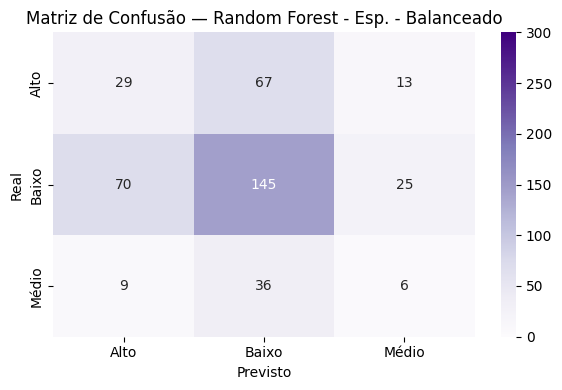

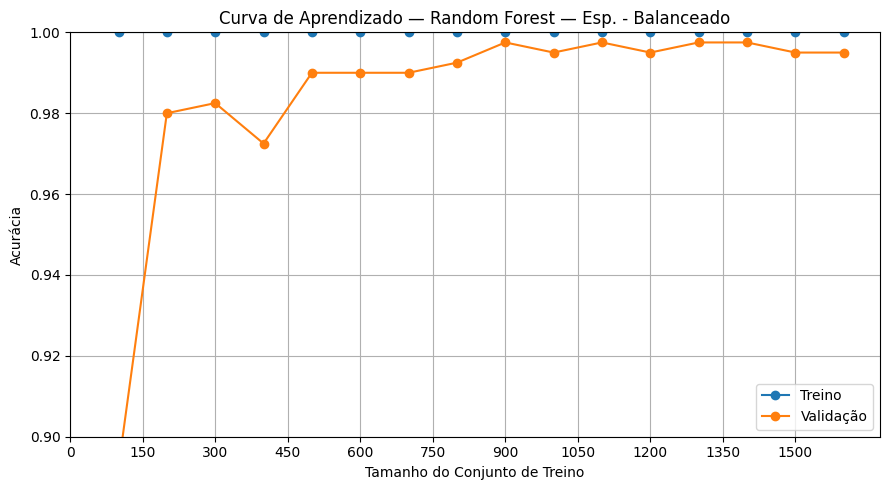

In [55]:
#RADHA COM SMOTE
#RANDON FOREST

# === 1. Carrega os dados ===
dados_entrada = pd.read_csv("dataset_radha_sem_risco_SMOTE.csv")
rotulos_risco = pd.read_csv("gabarito_radha_risco_SMOTE.csv")["risco"]

# === 2. Codifica os dados ===
codificador_rotulos = LabelEncoder()
rotulos_convertidos = codificador_rotulos.fit_transform(rotulos_risco)

entradas_convertidas = dados_entrada.apply(LabelEncoder().fit_transform)

# === 3. Separação Hold-out ===
#entradas_treino, entradas_teste, rotulos_treino, rotulos_teste = train_test_split(
#    entradas_convertidas, rotulos_convertidos,
#    test_size=0.2, random_state=42, stratify=rotulos_convertidos
#)
## === 4. Treinamento com Random Forest ===
#modelo_random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
#modelo_random_forest.fit(entradas_treino, rotulos_treino)
#rotulos_previstos = modelo_random_forest.predict(entradas_teste)

# === 5. Avaliação ===
print("\n🔹 Modelo Random Forest — Balanceado - Esp ")
print(classification_report(rotulos_teste, rotulos_previstos, target_names=codificador_rotulos.classes_))

# === 6. Matriz de Confusão ===
plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion_matrix(rotulos_teste, rotulos_previstos),
    annot=True, fmt='d', cmap='Purples',
    xticklabels=codificador_rotulos.classes_,
    yticklabels=codificador_rotulos.classes_,
    vmin=0, vmax=300  # ajuste para padronizar a escala
)
plt.title("Matriz de Confusão — Random Forest - Esp. - Balanceado")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("imagens/imagens/balanceado/MATRIZ-RD-ESP-BALANCEADO-01.png", dpi=300)
plt.show()

# === 7. Curva de Aprendizado Manual ===
tamanhos_amostras_treino = np.arange(100, len(entradas_treino) + 1, 100)
acuracias_treino = []
acuracias_teste = []

for tamanho_atual in tamanhos_amostras_treino:
    modelo_temporario = RandomForestClassifier(n_estimators=100, random_state=42)
    modelo_temporario.fit(entradas_treino[:tamanho_atual], rotulos_treino[:tamanho_atual])

    acuracia_treino_atual = accuracy_score(rotulos_treino[:tamanho_atual], modelo_temporario.predict(entradas_treino[:tamanho_atual]))
    acuracia_teste_atual = accuracy_score(rotulos_teste, modelo_temporario.predict(entradas_teste))

    acuracias_treino.append(acuracia_treino_atual)
    acuracias_teste.append(acuracia_teste_atual)

# === 8. Plot da Curva ===
plt.figure(figsize=(9, 5))
plt.plot(tamanhos_amostras_treino, acuracias_treino, 'o-', label="Treino")
plt.plot(tamanhos_amostras_treino, acuracias_teste, 'o-', label="Validação")

plt.title("Curva de Aprendizado — Random Forest — Esp. - Balanceado")
plt.xlabel("Tamanho do Conjunto de Treino")
plt.ylabel("Acurácia")
plt.xticks(tamanhos_amostras_treino)
plt.legend()
plt.legend(loc='lower right')
plt.grid(True)
plt.ylim(0.90, 1)
plt.xticks(np.arange(0, len(entradas_treino)+1, 150))  # X mais limpo e espaçado
plt.tight_layout()
plt.savefig("imagens/imagens/balanceado/CURVA-RD-ESP-BALANCEADO-01.png", dpi=300)
plt.show()

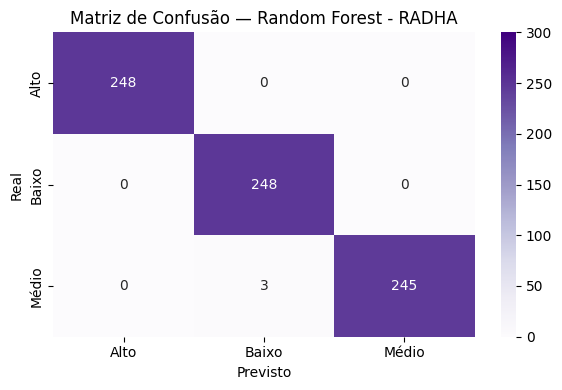

In [29]:
# === 6. Matriz de Confusão ===
plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion_matrix(rotulos_teste, rotulos_previstos),
    annot=True, fmt='d', cmap='Purples',
    xticklabels=codificador_rotulos.classes_,
    yticklabels=codificador_rotulos.classes_,
    vmin=0, vmax=300  # ajuste para padronizar a escala
)
plt.title("Matriz de Confusão — Random Forest - Especialista")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()



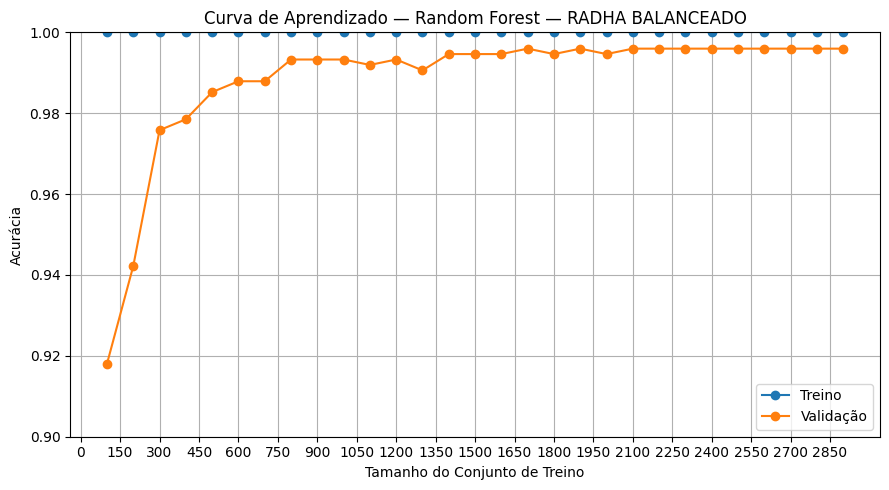

In [30]:
# === 7. Curva de Aprendizado Manual ===
tamanhos_amostras_treino = np.arange(100, len(entradas_treino) + 1, 100)
acuracias_treino = []
acuracias_teste = []

for tamanho_atual in tamanhos_amostras_treino:
    modelo_temporario = RandomForestClassifier(n_estimators=100, random_state=42)
    modelo_temporario.fit(entradas_treino[:tamanho_atual], rotulos_treino[:tamanho_atual])

    acuracia_treino_atual = accuracy_score(rotulos_treino[:tamanho_atual], modelo_temporario.predict(entradas_treino[:tamanho_atual]))
    acuracia_teste_atual = accuracy_score(rotulos_teste, modelo_temporario.predict(entradas_teste))

    acuracias_treino.append(acuracia_treino_atual)
    acuracias_teste.append(acuracia_teste_atual)

# === 8. Plot da Curva ===
plt.figure(figsize=(9, 5))
plt.plot(tamanhos_amostras_treino, acuracias_treino, 'o-', label="Treino")
plt.plot(tamanhos_amostras_treino, acuracias_teste, 'o-', label="Validação")

plt.title("Curva de Aprendizado — Random Forest — Esp. Balanceado")
plt.xlabel("Tamanho do Conjunto de Treino")
plt.ylabel("Acurácia")
plt.xticks(tamanhos_amostras_treino)
plt.legend()
plt.legend(loc='lower right')
plt.grid(True)
plt.ylim(0.90, 1)
plt.xticks(np.arange(0, len(entradas_treino)+1, 150))  # X mais limpo e espaçado
plt.tight_layout()
plt.savefig("imagens/imagens/balanceado/rd_radha_bal.png", dpi=300)
plt.show()


🔹 Modelo SVM — Esp. Balanceado
              precision    recall  f1-score   support

        Alto       0.98      0.85      0.91       245
       Baixo       0.89      0.67      0.76       267
       Médio       0.68      0.97      0.80       232

    accuracy                           0.82       744
   macro avg       0.85      0.83      0.82       744
weighted avg       0.85      0.82      0.82       744



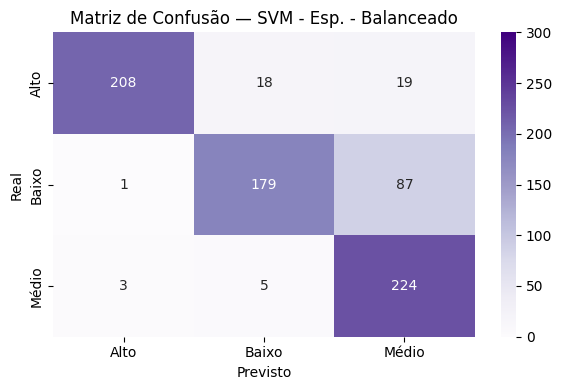

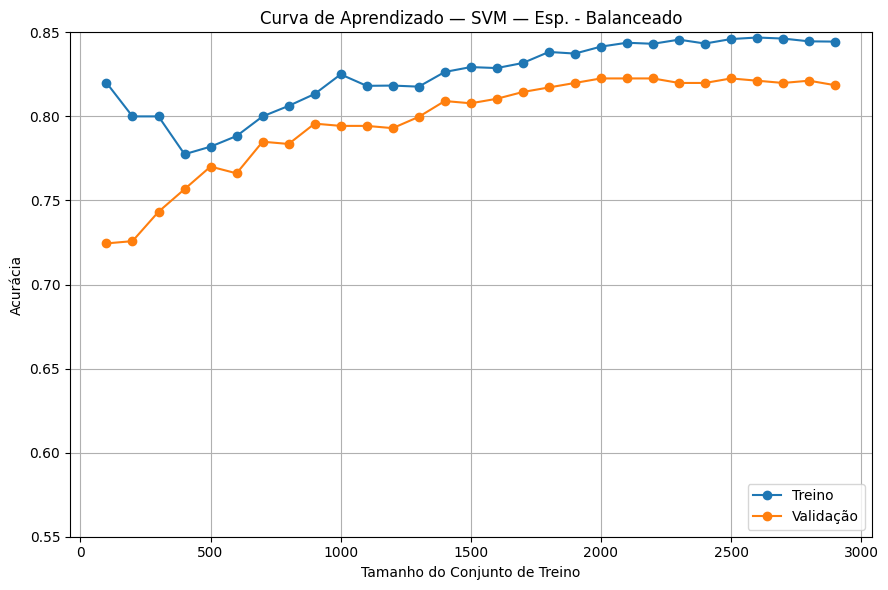

In [56]:
#SVM RADHA  - BALANCEADO 
# === 1. Carrega os dados ===
dados_entrada = pd.read_csv("dataset_radha_balanceado_SMOTE.csv")
rotulos_risco = pd.read_csv("gabarito_radha_risco_SMOTE.csv")["risco"]

# === 2. Codifica entradas e rótulos ===
rotulo_encoder = LabelEncoder()
rotulos_codificados = rotulo_encoder.fit_transform(rotulos_risco)
entradas_codificadas = dados_entrada.apply(LabelEncoder().fit_transform)

# === 3. Hold-out 80/20 ===
entradas_treino, entradas_teste, rotulos_treino, rotulos_teste = train_test_split(
    entradas_codificadas, rotulos_codificados, test_size=0.2, random_state=42
)

# === 4. Define o modelo SVM ===
modelo_svm = SVC(kernel='rbf', C=1.0, gamma='scale')

# === 5. Define os tamanhos de treino manualmente ===
tamanhos_treino = np.arange(100, len(entradas_treino)+1, 100)

# === 6. Matriz de Confusão (após último treinamento completo) ===
modelo_svm.fit(entradas_treino, rotulos_treino)
rotulos_previstos = modelo_svm.predict(entradas_teste)

print("\n🔹 Modelo SVM — Esp. Balanceado")
print(classification_report(rotulos_teste, rotulos_previstos, target_names=rotulo_encoder.classes_))

plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion_matrix(rotulos_teste, rotulos_previstos),
    annot=True, fmt='d', cmap='Purples',
    xticklabels=rotulo_encoder.classes_,
    yticklabels=rotulo_encoder.classes_,
    vmin=0, vmax=300  # ajuste para padronizar a escala
)
plt.title("Matriz de Confusão — SVM - Esp. - Balanceado")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("imagens/imagens/balanceado/MATRIZ-SVM-ESP-BALANCEADO-01.png", dpi=300)
plt.show()

# === 7. Curva de aprendizado manual ===
scores_treino = []
scores_validacao = []

for tamanho in tamanhos_treino:
    modelo_svm.fit(entradas_treino[:tamanho], rotulos_treino[:tamanho])
    
    acc_train = accuracy_score(rotulos_treino[:tamanho], modelo_svm.predict(entradas_treino[:tamanho]))
    acc_test = accuracy_score(rotulos_teste, modelo_svm.predict(entradas_teste))
    
    scores_treino.append(acc_train)
    scores_validacao.append(acc_test)

# === 7. Plot ===
plt.figure(figsize=(9, 6))
plt.plot(tamanhos_treino, scores_treino, 'o-', label="Treino")
plt.plot(tamanhos_treino, scores_validacao, 'o-', label="Validação")

plt.title("Curva de Aprendizado — SVM — Esp. - Balanceado")
plt.xlabel("Tamanho do Conjunto de Treino")
plt.ylabel("Acurácia")
plt.legend()
plt.legend(loc='lower right')
plt.grid(True)
plt.ylim(0.55, 0.85)
plt.tight_layout()
plt.savefig("imagens/imagens/balanceado/CURVA-SVM-ESP-BALANCEADO-01.png", dpi=300)
plt.show()


Fitting 3 folds for each of 24 candidates, totalling 72 fits



🔹 Modelo MLP — Hold-out 80/20 — Dataset RADHA - NÃO BALANCEADO
Melhores parâmetros encontrados: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
              precision    recall  f1-score   support

        Alto       1.00      1.00      1.00       108
       Baixo       1.00      0.99      0.99       248
       Médio       0.96      0.98      0.97        44

    accuracy                           0.99       400
   macro avg       0.98      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



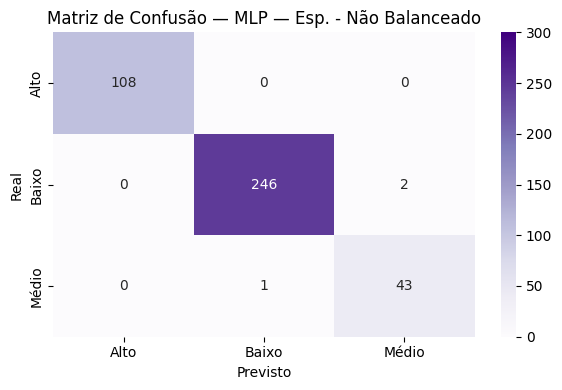

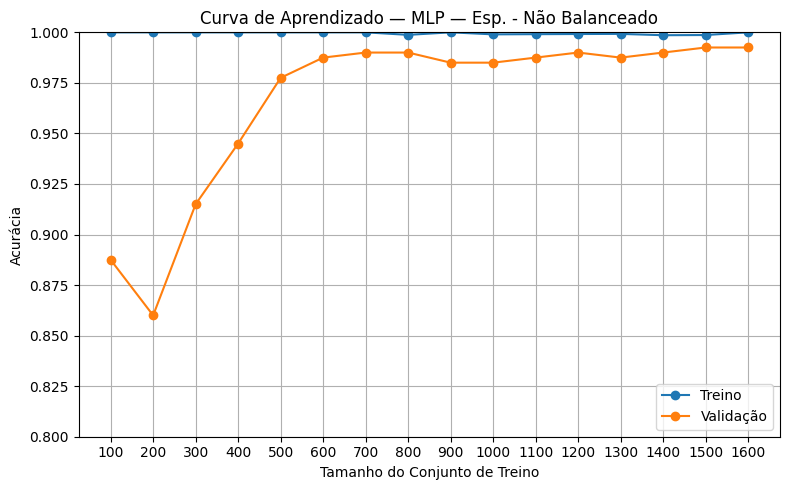

In [57]:
#REDE NEURAL - SEM BALANCEAMENTO - RADHA

# === 1. Carrega os dados ===
dados_entrada = pd.read_csv("dataset_radha_sem_risco.csv")
rotulos_risco = pd.read_csv("gabarito_radha_risco.csv")["risco"]

# === 2. Codifica entradas e rótulos ===
rotulo_encoder = LabelEncoder()
rotulos_codificados = rotulo_encoder.fit_transform(rotulos_risco)
entradas_codificadas = dados_entrada.apply(LabelEncoder().fit_transform)

# === 3. Padronização dos dados ===
escalador = StandardScaler()
entradas_normalizadas = escalador.fit_transform(entradas_codificadas)

# === 4. Separação Hold-out 80/20 ===
entradas_treino, entradas_teste, rotulos_treino, rotulos_teste = train_test_split(
    entradas_normalizadas, rotulos_codificados,
    test_size=0.2, random_state=42, stratify=rotulos_codificados
)

# === 5. GridSearchCV para otimizar MLP ===
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001]
}

grid_search = GridSearchCV(
    MLPClassifier(max_iter=1000, random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(entradas_treino, rotulos_treino)
melhor_modelo = grid_search.best_estimator_

# === 6. Avaliação final ===
rotulos_previstos = melhor_modelo.predict(entradas_teste)

print("\n🔹 Modelo MLP — Hold-out 80/20 — Dataset RADHA - NÃO BALANCEADO")
print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")
print(classification_report(rotulos_teste, rotulos_previstos, target_names=rotulo_encoder.classes_))

# === 7. Matriz de Confusão ===
plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion_matrix(rotulos_teste, rotulos_previstos),
    annot=True, fmt='d', cmap='Purples',
    xticklabels=rotulo_encoder.classes_,
    yticklabels=rotulo_encoder.classes_,
    vmin=0, vmax=300  # ajuste para padronizar a escala
)
plt.title("Matriz de Confusão — MLP — Esp. - Não Balanceado")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("imagens/imagens/sem balancear/MATRIZ-MLP-ESP-NO-BALANCE-01.png", dpi=300)
plt.show()

# === 8. Salva o modelo treinado ===
joblib.dump(melhor_modelo, "modelo_mlp_radha.pkl")

# === 9. Curva de Aprendizado Manual ===
tamanhos_amostras_treino = np.arange(100, len(entradas_treino) + 1, 100)
acuracias_treino = []
acuracias_teste = []

for tamanho_atual in tamanhos_amostras_treino:
    modelo_temp = MLPClassifier(**grid_search.best_params_, max_iter=1000, random_state=42)
    modelo_temp.fit(entradas_treino[:tamanho_atual], rotulos_treino[:tamanho_atual])
    
    acc_train = accuracy_score(rotulos_treino[:tamanho_atual], modelo_temp.predict(entradas_treino[:tamanho_atual]))
    acc_test = accuracy_score(rotulos_teste, modelo_temp.predict(entradas_teste))

    acuracias_treino.append(acc_train)
    acuracias_teste.append(acc_test)

# === 10. Plot da Curva de Aprendizado ===
plt.figure(figsize=(8, 5))
plt.plot(tamanhos_amostras_treino, acuracias_treino, 'o-', label="Treino")
plt.plot(tamanhos_amostras_treino, acuracias_teste, 'o-', label="Validação")

plt.title("Curva de Aprendizado — MLP — Esp. - Não Balanceado")
plt.xlabel("Tamanho do Conjunto de Treino")
plt.ylabel("Acurácia")
plt.ylim(0.8, 1.0)
plt.xticks(tamanhos_amostras_treino)
plt.legend()
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("imagens/imagens/sem balancear/CURVA-MLP-ESP-NO-BALANCE-01.png", dpi=300)
plt.show()

Fitting 3 folds for each of 24 candidates, totalling 72 fits

🔹 Modelo MLP — Hold-out 80/20 — Dataset Esp. BALANCEADO
Melhores parâmetros encontrados: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
              precision    recall  f1-score   support

        Alto       1.00      1.00      1.00       248
       Baixo       0.99      1.00      0.99       248
       Médio       1.00      0.99      0.99       248

    accuracy                           0.99       744
   macro avg       0.99      0.99      0.99       744
weighted avg       0.99      0.99      0.99       744



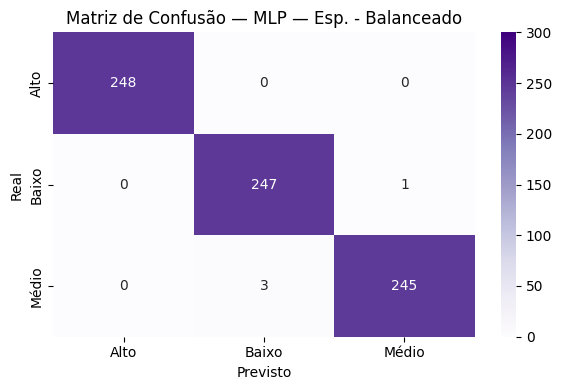

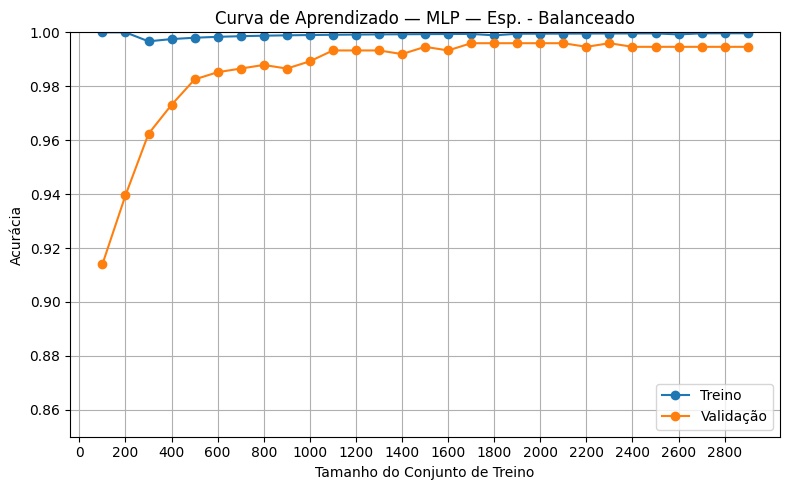

In [58]:
#REDE NEURAL - COM BALANCEAMENTO

# === 1. Carrega os dados ===
dados_entrada = pd.read_csv("dataset_radha_sem_risco_SMOTE.csv")
rotulos_risco = pd.read_csv("gabarito_radha_risco_SMOTE.csv")["risco"]

# === 2. Codifica entradas e rótulos ===
rotulo_encoder = LabelEncoder()
rotulos_codificados = rotulo_encoder.fit_transform(rotulos_risco)
entradas_codificadas = dados_entrada.apply(LabelEncoder().fit_transform)

# === 3. Padronização dos dados ===
escalador = StandardScaler()
entradas_normalizadas = escalador.fit_transform(entradas_codificadas)

# === 4. Separação Hold-out 80/20 ===
entradas_treino, entradas_teste, rotulos_treino, rotulos_teste = train_test_split(
    entradas_normalizadas, rotulos_codificados,
    test_size=0.2, random_state=42, stratify=rotulos_codificados
)

# === 5. GridSearchCV para otimizar MLP ===
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001]
}

grid_search = GridSearchCV(
    MLPClassifier(max_iter=1000, random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(entradas_treino, rotulos_treino)
melhor_modelo = grid_search.best_estimator_

# === 6. Avaliação final ===
rotulos_previstos = melhor_modelo.predict(entradas_teste)

print("\n🔹 Modelo MLP — Hold-out 80/20 — Dataset Esp. BALANCEADO")
print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")
print(classification_report(rotulos_teste, rotulos_previstos, target_names=rotulo_encoder.classes_))

# === 7. Matriz de Confusão ===
plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion_matrix(rotulos_teste, rotulos_previstos),
    annot=True, fmt='d', cmap='Purples',
    xticklabels=rotulo_encoder.classes_,
    yticklabels=rotulo_encoder.classes_,
    vmin=0, vmax=300  # ajuste para padronizar a escala
)
plt.title("Matriz de Confusão — MLP — Esp. - Balanceado")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("imagens/imagens/balanceado/MATRIZ-MLP-ESP-BALANCEADO-01.png", dpi=300)
plt.show()

# === 8. Salva o modelo treinado ===
joblib.dump(melhor_modelo, "modelo_mlp_radha.pkl")

# === 9. Curva de Aprendizado Manual ===
tamanhos_amostras_treino = np.arange(100, len(entradas_treino) + 1, 100)
acuracias_treino = []
acuracias_teste = []

for tamanho_atual in tamanhos_amostras_treino:
    modelo_temp = MLPClassifier(**grid_search.best_params_, max_iter=1000, random_state=42)
    modelo_temp.fit(entradas_treino[:tamanho_atual], rotulos_treino[:tamanho_atual])
    
    acc_train = accuracy_score(rotulos_treino[:tamanho_atual], modelo_temp.predict(entradas_treino[:tamanho_atual]))
    acc_test = accuracy_score(rotulos_teste, modelo_temp.predict(entradas_teste))

    acuracias_treino.append(acc_train)
    acuracias_teste.append(acc_test)

# === 10. Plot da Curva de Aprendizado ===
plt.figure(figsize=(8, 5))
plt.plot(tamanhos_amostras_treino, acuracias_treino, 'o-', label="Treino")
plt.plot(tamanhos_amostras_treino, acuracias_teste, 'o-', label="Validação")

plt.title("Curva de Aprendizado — MLP — Esp. - Balanceado")
plt.xlabel("Tamanho do Conjunto de Treino")
plt.ylabel("Acurácia")
plt.ylim(0.85, 1.0)
plt.xticks(tamanhos_amostras_treino)
plt.xticks(np.arange(0, len(entradas_treino)+1, 200)) 
plt.legend()
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("imagens/imagens/balanceado/CURVA-MLP-ESP-BALANCEADO-01.png", dpi=300)
plt.show()